### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

In [9]:
# lines grouped together based on delay frequency
line_groups = [
    ["N", "A", "F", "6", "2", "E"],
    ["Q", "D", "4", "1"],
    ["R", "7", "C", "5", "3"],
    ["L", "B", "JZ", "G", "M"]
]

group_to_use = line_groups[3]

# Data Cleaning

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

# replace "Other Operating Environment" with "Operating Conditions" to maintain parity
# a new "Service Management" subcategory was added in Aug 2024 which
# replaces the empty subcategory for "Operating Conditions"
df['subcategory'] = df['subcategory'].replace("Other Operating Environment", "Operating Conditions")

# drop the division and reporting_category columns, they are redundance info
df = df.drop(columns=['division', 'reporting_category'])

# remove S Rock, S Fkln, and GS (shuttles)
df = df[~df['line'].isin(['S Rock', 'S Fkln', 'GS'])]

df

,month,line,day_type,subcategory,delays
0,2024-10-01,1,1,Crew Availability,60
1,2024-10-01,1,1,External Debris on Roadbed,17
2,2024-10-01,1,1,Braking,20
3,2024-10-01,1,1,Door-Related,43
4,2024-10-01,1,1,"Fire, Smoke, Debris",30
...,...,...,...,...,...
39025,2020-01-01,R,2,Subways Maintenance,23
39026,2020-01-01,R,2,Work Equipment,3
39027,2020-01-01,R,2,Persons on Roadbed,4
39028,2020-01-01,R,2,"Public Conduct, Crime, Police Response",31


# Data Reshaping

In [11]:

# reshape each line
lines_df = {}
for line in df['line'].unique():
    line_df = df[df['line'] == line]

    # drop line since we're only looking at one line
    line_df = line_df.drop(columns=['line'])

    # pivot the delay subcategory rows into columns
    line_df = line_df.pivot(index=['month', 'day_type'], columns='subcategory', values='delays').fillna(0)

    # add 2 rows with the same month but different day type, keep the month column
    line_df = line_df.groupby('month').sum()

    # sum the delays for each month
    line_df['total_delays'] = line_df.sum(axis=1)

    lines_df[line] = line_df

# concatenate all the lines we want to consider into one dataframe
group_df = None
for line in group_to_use:
    if line == group_to_use[0]:
        group_df = lines_df[line]
    else:
        group_df = pd.concat([group_df, lines_df[line]], axis=0).fillna(0)
    

features = group_df.drop(columns=['total_delays'])
target = group_df['total_delays']

group_df

In [12]:

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = np.array(target).reshape(-1, 1)
scaled_target = scaler.fit_transform(scaled_target)

# Create sequences for LSTM input
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Use the last 6 time steps to predict the next
sequence_length = 6 
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Reshape X to be 3D: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])


num_rows = lines_df["1"].shape[0]
n = len(group_to_use)

end = num_rows*(n-1)
# select n - 1 lines for training
X_train = X[:end]
X_test = X[end:]

# select the last line for testing
y_train = y[:end]
y_test = y[end:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232, 6, 25), (50, 6, 25), (232, 1), (50, 1))

In [13]:
print(X_train.shape[1], X_train.shape[2])
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


6 25
Epoch 1/50


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0683 - val_loss: 0.0222
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - val_loss: 0.0218
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0171
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - val_loss: 0.0143
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - val_loss: 0.0144
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 13/50
8/8 ━━━━━━

In [14]:
y_pred = model.predict(X_test)
# Invert scaling to get the actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

print(y_pred)
print(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[[ 641.64844]
 [ 650.2169 ]
 [ 631.5085 ]
 [ 606.2016 ]
 [ 564.3295 ]
 [ 652.9272 ]
 [ 611.2576 ]
 [ 599.13916]
 [ 584.301  ]
 [ 629.2391 ]
 [ 786.22723]
 [ 999.6639 ]
 [1067.3301 ]
 [1021.9841 ]
 [1041.4872 ]
 [1183.5688 ]
 [1331.2128 ]
 [1028.6565 ]
 [1152.175  ]
 [1390.4679 ]
 [1296.0658 ]
 [1191.1083 ]
 [ 944.52386]
 [ 861.364  ]
 [ 757.6157 ]
 [ 564.57904]
 [ 538.0392 ]
 [ 544.5933 ]
 [ 510.34488]
 [ 483.10913]
 [ 547.7467 ]
 [ 623.23364]
 [ 670.8927 ]
 [ 793.00433]
 [ 890.8781 ]
 [ 840.95233]
 [ 721.31445]
 [ 685.3859 ]
 [ 549.26575]
 [ 657.3937 ]
 [ 807.95386]
 [ 786.90063]
 [ 840.7223 ]
 [ 785.3291 ]
 [1069.071  ]
 [1342.0494 ]
 [1453.3739 ]
 [1530.1357 ]
 [1408.4185 ]
 [1305.5293 ]]
[[ 374.]
 [ 395.]
 [ 376.]
 [ 398.]
 [ 850.]
 [ 694.]
 [ 554.]
 [ 524.]
 [ 726.]
 [1205.]
 [1260.]
 [1160.]
 [1248.]
 [1262.]
 [1274.]
 [1524.]
 [1170.]
 [1111.]
 [1319.]
 [1257.]
 [1026.]
 [1488.]
 [1549.]
 [1491.]
 [1302.]
 [1234.]
 [1237.]
 [1194.]
 [ 908.]


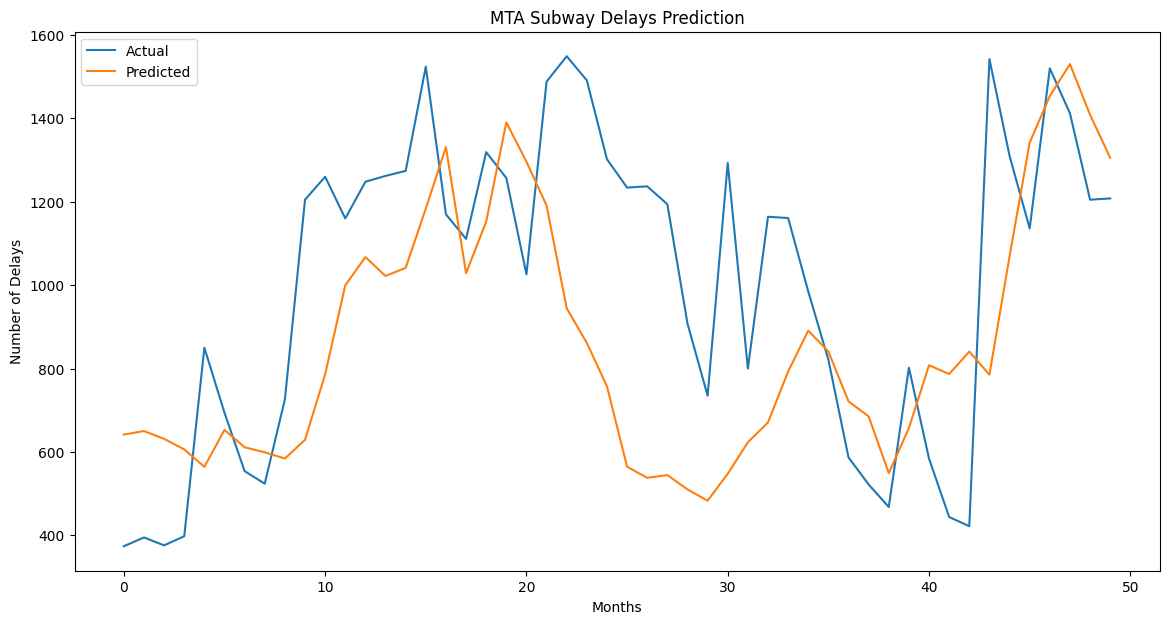

In [15]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('MTA Subway Delays Prediction')
plt.ylabel("Number of Delays")
plt.xlabel("Months")
plt.legend()
plt.show()